# Supplementary Figure 6

This notebook needs ClearMap environment.  
First, clone ClearMap environment from github (https://christophkirst.github.io/ClearMap2Documentation/html/installation.html) and put this notebook to "ClearMap2/ClearMap/Scripts".  

In [ ]:
import shutil
import os
import glob
import sys
import itertools
from pathlib import Path
sys.path.append('../../') # ClearMap2 Folder
from ClearMap.Environment import *  #analysis:ignore
import tifffile
import warnings
import pandas as pd
from scipy import stats
warnings.simplefilter('ignore')

In [ ]:
# Download demo data
!wget https://www.dropbox.com/s/th5jlc4qxeuw7zv/data_fig6c%28fibrosis%29.zip
!wget https://www.dropbox.com/s/81gmuoipz2f8kvd/data_fig7f%28tumor%29.zip
!wget https://www.dropbox.com/s/6g4qr7jtqv5tuch/data_supfig6%28brain%29.zip
    
!unzip "data_fig6c(fibrosis).zip"
!unzip "data_fig7f(tumor).zip"
!unzip "data_supfig6(brain).zip"

datadir = "../../ClearMap/Data"
if not os.path.exists(datadir):
    os.mkdir(datadir)
resultdir = "../../ClearMap/Results"
if not os.path.exists(resultdir):
    os.mkdir(resultdir)

shutil.move("data_fig6c(fibrosis)", datadir)
shutil.move("data_fig7f(tumor)", datadir)
shutil.move("data_supfig6(brain)", datadir)

!rm "data_fig6c(fibrosis).zip"
!rm "data_fig7f(tumor).zip"
!rm "data_supfig6(brain).zip"

--2022-08-10 22:14:11--  https://www.dropbox.com/s/th5jlc4qxeuw7zv/data_fig6c%28fibrosis%29.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/th5jlc4qxeuw7zv/data_fig6c%28fibrosis%29.zip [following]
--2022-08-10 22:14:12--  https://www.dropbox.com/s/raw/th5jlc4qxeuw7zv/data_fig6c%28fibrosis%29.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5de0f5903a87111b4fbadd4adf.dl.dropboxusercontent.com/cd/0/inline/BqvrAX6HMffecg7hce4rEd7BK9kUqIpNtGnUBEJ0N2uF3459rbn818kurWI8f658CN2MPc3p_4FmNn0RGMIBS6HyP0Sj9Vy2a85QEyCN0ZEQH7-vED05MpCpPhtO2u6MvXPBDHnZVaSRdg6pfeo8wQK_P2PD9nhPZ5DdD4lWA6kxCg/file# [following]
--2022-08-10 22:14:12--  https://uc5de0f5903a87111b4fbadd4adf.dl.dropboxusercontent.com/cd/0/inline/BqvrAX6HMffecg7hc

HTTP request sent, awaiting response... 200 OK
Length: 520895003 (497M) [application/zip]
Saving to: ‘data_supfig6(brain).zip’

100%[======================================>] 520,895,003 17.0MB/s   in 30s    

2022-08-10 22:14:55 (16.8 MB/s) - ‘data_supfig6(brain).zip’ saved [520895003/520895003]

Archive:  data_fig6c(fibrosis).zip
   creating: data_fig6c(fibrosis)/
   creating: data_fig6c(fibrosis)/bleomycin/
   creating: data_fig6c(fibrosis)/bleomycin/no160/
  inflating: data_fig6c(fibrosis)/bleomycin/no160/graph_reduced.gt  
   creating: data_fig6c(fibrosis)/bleomycin/no190/
  inflating: data_fig6c(fibrosis)/bleomycin/no190/graph_reduced.gt  
   creating: data_fig6c(fibrosis)/bleomycin/no203/
  inflating: data_fig6c(fibrosis)/bleomycin/no203/graph_reduced.gt  
   creating: data_fig6c(fibrosis)/bleomycin/no205/
  inflating: data_fig6c(fibrosis)/bleomycin/no205/graph_reduced.gt  
   creating: data_fig6c(fibrosis)/bleomycin/no225/
  inflating: data_fig6c(fibrosis)/bleomycin/no225/graph_

# Brain

Separate brain into 14 regions (isocortex, cerebellum etc.) and extract subgraph, calculate graph properties (number of vertex, edge etc.).

In [ ]:
def exportVertexTIFF(graph, savename="subgraph.tif"):
    graph = graph
    shape = io.shape(reference_file)
    # print(shape)
    tiff = np.zeros(shape).astype("uint8")

    for c in graph.vertex_property_map(name="coordinates_atlas"):
    #     print(c)
        c = np.array(c).astype("int")
        tiff[c[0]][c[1]][c[2]] = 255
        
    savedir = os.path.join(directory, savename)
    tifffile.imsave(savedir, tiff)

In [ ]:
# regionname : [level, order]
regions = {"Cerebellum" : [3, 1006],
           "Cortical subplate" : [5, 564],
           "fiber tracts" : [2, 1093],
           "Hippocampal formation" : [6, 463],
           "Hypothalamus" : [5, 724],
           "Isocortex" : [6, 6],
           "Midbrain" : [4, 811],
           "Medulla" : [5, 927],
           "Olfactory areas" : [6, 388],
           "Pons" : [5, 876],
           "Pallidum" : [5, 617],
           "Striatum" : [5, 580],
           "Thalamus" : [5, 650],
           "ventricular systems" : [2, 1284],
           }

In [ ]:
class SubGraph:
    def __init__(self, ws):
        self.graph_c = grp.load(ws.filename('graph', postfix='annotated_capillary'));
        self.graph_m = grp.load(ws.filename('graph', postfix='annotated_mature'));
        self.extractSubGraph()
        self.extractProperty()
            
    def extractSubGraph(self):
        self.subgraph_c = {}
        self.subgraph_m = {}
        
        # sub-graph extraction
        for region in list(regions.keys()):
            graph = self.graph_c
            level = regions[region][0]
            color_order = regions[region][1]

            # sub-graph extraction capillary
            label = graph.vertex_annotation();
            label_leveled = ano.convert_label(label, key='order', value='order', level=level)
            vertex_filter = label_leveled == color_order;
            gs = graph.sub_graph(vertex_filter=vertex_filter);
            self.subgraph_c[region] = gs
            
            graph = self.graph_m
            level = regions[region][0]
            color_order = regions[region][1]

            # sub-graph extraction mature
            label = graph.vertex_annotation();
            label_leveled = ano.convert_label(label, key='order', value='order', level=level)
            vertex_filter = label_leveled == color_order;
            gs = graph.sub_graph(vertex_filter=vertex_filter);
            self.subgraph_m[region] = gs
            
    def extractProperty(self):
        self.vr_c, self.vr_m = {}, {}
        self.er_c, self.er_m = {}, {}
        self.egr_c, self.egr_m = {}, {}
        
        for region in list(regions.keys()):
            self.vr_c[region]  = self.subgraph_c[region].edge_property(name="radii_atlas")
            self.er_c[region]  = self.subgraph_c[region].vertex_property(name="radii_atlas")
            self.egr_c[region] = self.subgraph_c[region].graph_property(name="edge_geometry_radii_atlas")
            self.vr_m[region]  = self.subgraph_m[region].edge_property(name="radii_atlas")
            self.er_m[region]  = self.subgraph_m[region].vertex_property(name="radii_atlas")
            self.egr_m[region] = self.subgraph_m[region].graph_property(name="edge_geometry_radii_atlas")
            
    def createHistogram(self, bins=np.arange(0,5,0.1)):
        self.hist = {}
        self.hist["capillary"] = {}
        self.hist["mature"] = {}
        
        for p, r_c, r_m in zip(["vertex_radii_atlas", "edge_radii_atlas", "edge_geometry_radii_atlas"], 
                               [self.vr_c, self.er_c, self.egr_c], [self.vr_m, self.er_m, self.egr_m]):
            self.hist["capillary"][p] = {}
            self.hist["mature"][p] = {}
            for region in list(regions.keys()):
                arr = np.histogram(r_m[region], bins=bins)[0]
                arr = arr / np.sum(arr)
                self.hist["capillary"][p][region] = arr
                arr = np.histogram(r_c[region], bins=bins)[0]
                arr = arr / np.sum(arr)
                self.hist["mature"][p][region] = arr

In [ ]:
def plotBarAllGraph(gs_list, channel, properties_name, properties, scale_dic, savedir, savename=None, save=False, returndf=True):
    y_means = []
    y_stds = []
    y_percentiles1 = []
    y_percentiles2 = []
    
    for gs in gs_list:
        
        if channel == "capillary":
            gs = gs.subgraph_c
        elif channel == "mature":
            gs = gs.subgraph_m
            
        y_mean = []
        y_std = []
        y_percentile1 = []
        y_percentile2 = []
        for region in list(regions.keys()):
            if properties_name == "vertex":
                arr = gs[region].vertex_property(name=properties)
            elif properties_name == "edge":
                arr = gs[region].edge_property(name=properties)
            elif properties_name == "graph":
                arr = gs[region].graph_property(name=properties)

            y_mean += [np.mean(arr)]
            y_std += [np.std(arr)]
            y_percentile1 += [np.percentile(arr, 25)]
            y_percentile2 += [np.percentile(arr, 75)]
        y_means += [y_mean]
        y_stds += [y_std]
        y_percentiles1 += [y_percentile1]
        y_percentiles2 += [y_percentile2]
        
        
    # Plot
    color_list = ["tan", "orange", "darkseagreen", "red", "darkkhaki", "limegreen", "green",
              "gold", "maroon", "darkslategrey", "teal", "coral", "cornflowerblue", "sandybrown"]
    width = 0.2
    
    plt.figure(figsize=(15,8))
    plt.title(f"{channel} {properties_name} {properties}", fontsize=24)
    plt.ylim(0, scale_dic[properties_name][properties])
    for i in range(len(gs_list)):
        x = np.arange(len(regions)) + width * (i - (len(gs_list) / 2) + 0.5)
        y_mean = y_means[i]
        y_std = y_stds[i]
        y_percentile1 = np.array(y_percentiles1[i])
        y_percentile2 = np.array(y_percentiles2[i])
        y_err = np.array([abs(y_mean - y_percentile1), abs(y_mean - y_percentile2)])
        
        plt.bar(x, y_mean, width=width, color=color_list)
#         plt.errorbar(x, y_mean, y_std, capsize=2, color="black", fmt="o", markersize=0, linewidth=1)
        plt.errorbar(x, y_mean, yerr=y_err, capsize=2, color="black", fmt="o", markersize=0, linewidth=1)
        plt.xticks(np.arange(len(regions)), list(regions.keys()), rotation=30)
        
    if save:
        plt.savefig(f"{savedir}/{savename}", dpi=256)
    plt.tight_layout()
    plt.show()
    
    if returndf:
        df = pd.DataFrame(y_means, columns=list(regions.keys()))
        return df

In [ ]:
def plotBarAllGraph_VertexEdge(gs_list, channel, properties_name, scale_dic, savedir, savename=None, save=False, returndf=False):
    nums = []
    
    for gs in gs_list:
        
        if channel == "capillary":
            gs = gs.subgraph_c
        elif channel == "mature":
            gs = gs.subgraph_m
            
        num = []

        for region in list(regions.keys()):
            if properties_name == "vertex":
                num += [len(gs[region].vertices)]
            elif properties_name == "edge":
                num += [len(gs[region].edges)]

        nums += [num]
        
    # Plot
    color_list = ["tan", "orange", "darkseagreen", "red", "darkkhaki", "limegreen", "green",
              "gold", "maroon", "darkslategrey", "teal", "coral", "cornflowerblue", "sandybrown"]
    width = 0.2
    
    plt.figure(figsize=(15,8))
    plt.title(f"{channel} {properties_name}", fontsize=24)
    plt.ylim(0, scale_dic[properties_name])
    for i in range(len(gs_list)):
        x = np.arange(len(regions)) + width * (i - (len(gs_list) / 2) + 0.5)
        num = nums[i]
        
        plt.bar(x, num, width=width, color=color_list)
        plt.xticks(np.arange(len(regions)), list(regions.keys()), rotation=30)
        
        
    if save:
        plt.savefig(f"{savedir}/{savename}", dpi=256)
    plt.tight_layout()
    plt.show()
    
    if returndf:
        df = pd.DataFrame(nums, columns=list(regions.keys()))
        return df

In [ ]:
def find_all_files(directory):
    for root, dirs, files in os.walk(directory):
        yield root
        for file in files:
            yield os.path.join(root, file)

# Data class
class Data:
    def __init__(self, projectname=None):
        # parent directory
        self.parentdir = Path(os.getcwd()).parent
        # project directory
        if projectname != None:
            self.projectdir = projectname
        else:
            self.projectdir = Path(os.getcwd())
                
    def printFiles(self):
        for f in find_all_files(self.projectdir):
            print(f)

    def searchFile(self, extension, name=[], exclude=[]):
        dirlist_all = []
        dirlist = []
        
        for f in find_all_files(self.projectdir):
            dirlist_all += [f]
        
        if type(extension) == list:
            for n in extension:
                dirlist += [f for f in dirlist_all if f".{n}" in f]

        elif type(extension) == str:
            dirlist = [f for f in dirlist_all if f".{extension}" in f]
        
        if type(name) == list:
            for n in name:
                dirlist = [f for f in dirlist if f"{n}" in f]

        elif type(name) == str:
            dirlist = [f for f in dirlist if f"{name}" in f]
            
        if type(exclude) == list:
            for n in exclude:
                dirlist = [f for f in dirlist if not f"{n}" in f]

        elif type(exclude) == str:
            dirlist = [f for f in dirlist if not f"{exclude}" in f]
            
        return dirlist

In [ ]:
d = Data("../Data/data_supfig6(brain)")
sma = d.searchFile(extension="gt",name=["mature","annotated"])
display(sma)

['../Data/data_supfig6(brain)/190222_no53/graph_annotated_mature.gt',
 '../Data/data_supfig6(brain)/190222_no59/graph_annotated_mature.gt',
 '../Data/data_supfig6(brain)/191217_no74/graph_annotated_mature.gt',
 '../Data/data_supfig6(brain)/191217_no75/graph_annotated_mature.gt']

In [ ]:
savedir = os.path.join(resultdir, "brain")
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [ ]:
# Extract SubGraph from Graph(.gt)
gs_list = []
bins = np.arange(0,2,0.1)

for mouse in sma:
    directory = mouse.rsplit("/",1)[0]
    resources_directory = settings.resources_path

    ws = wsp.Workspace('TubeMap', directory=directory)
    gs = SubGraph(ws)
    gs.createHistogram(bins=bins)
    gs_list += [gs]

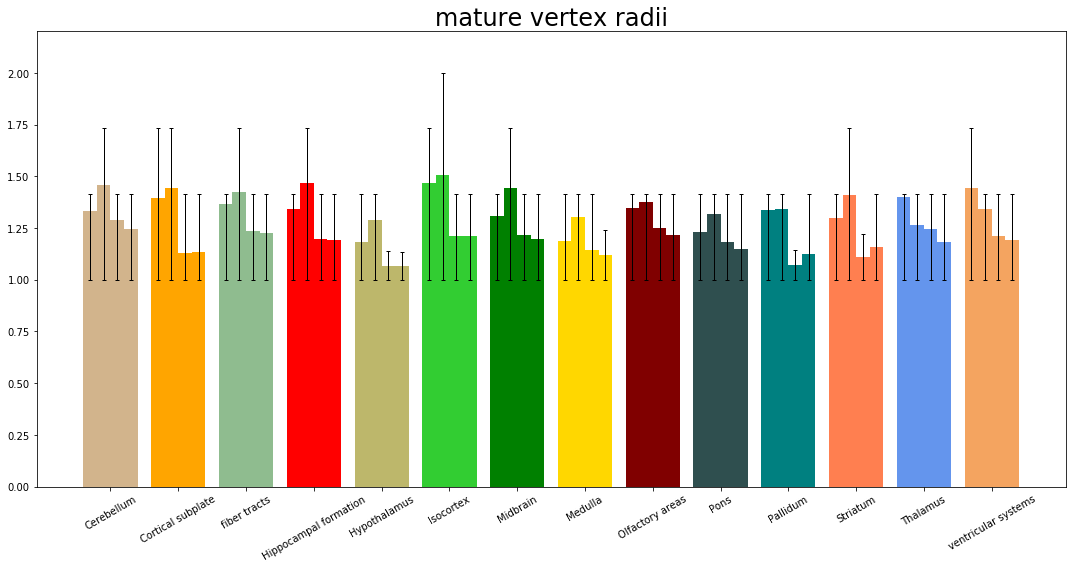

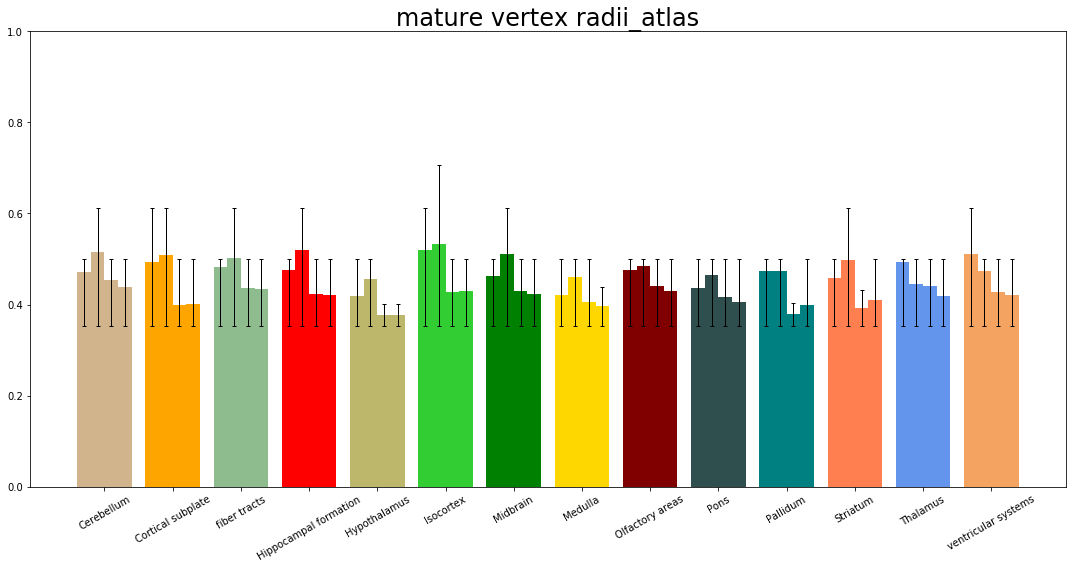

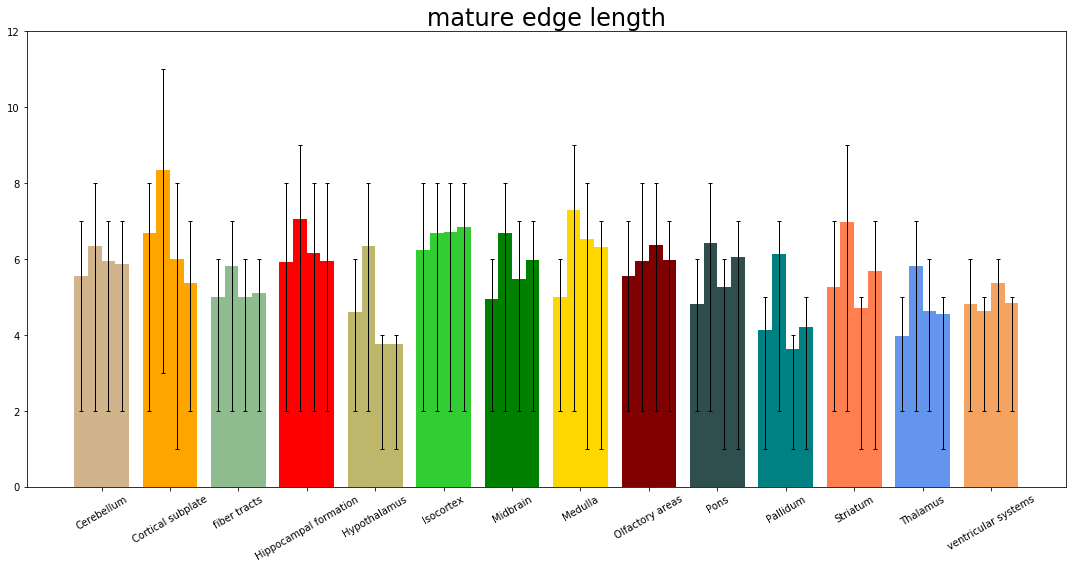

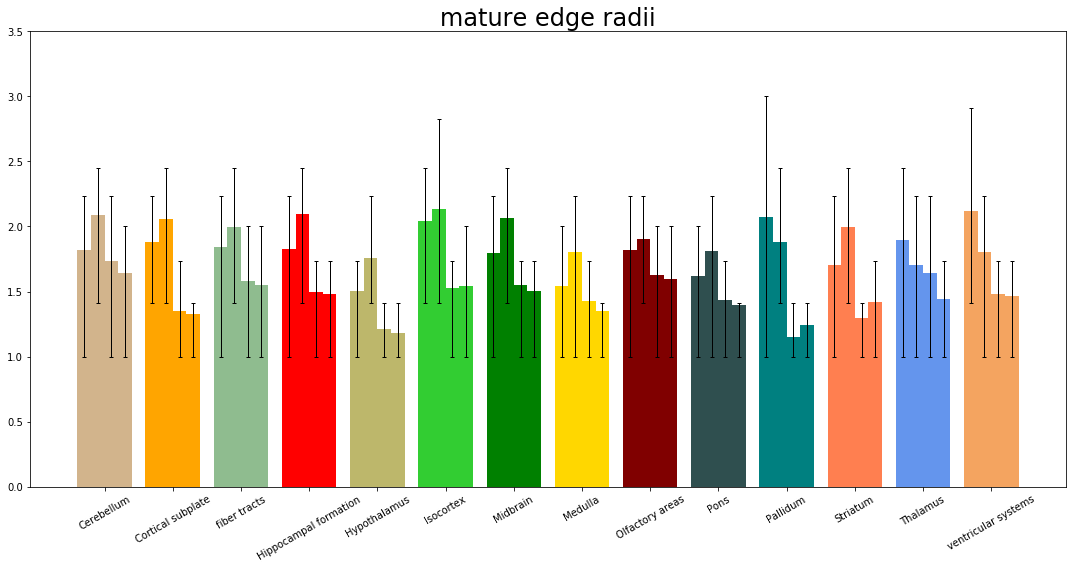

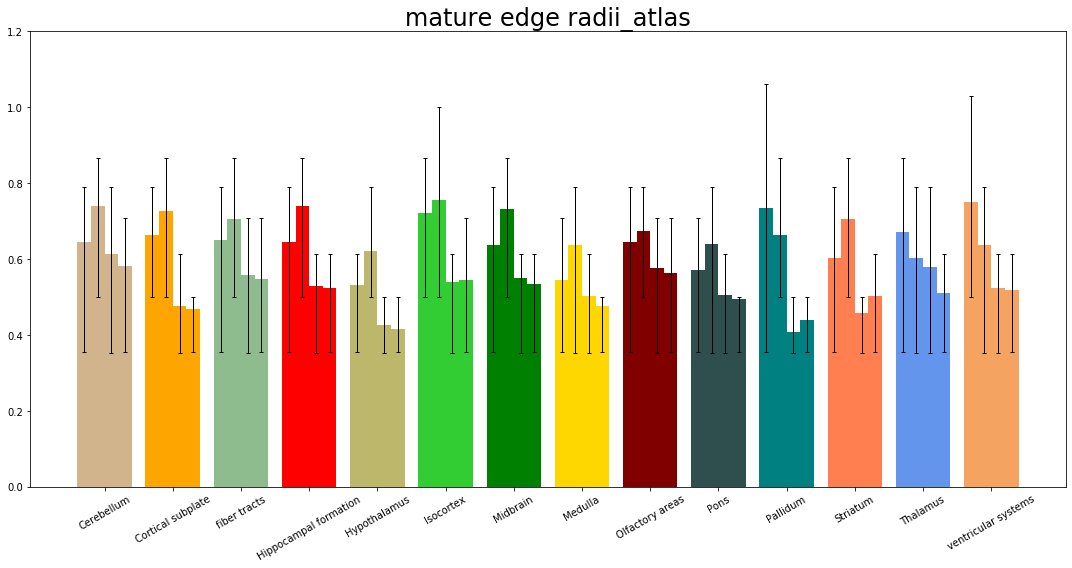

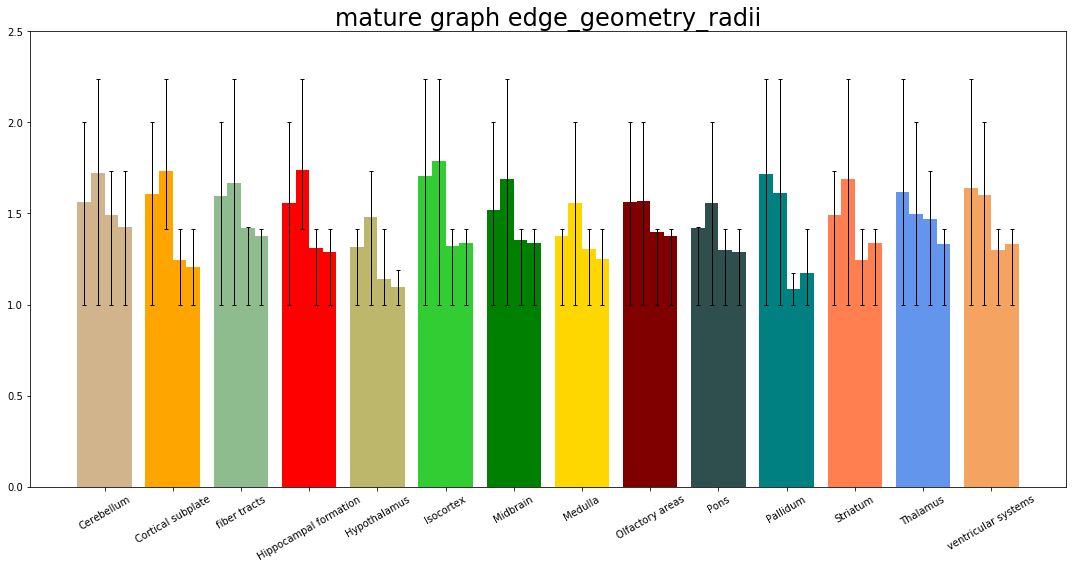

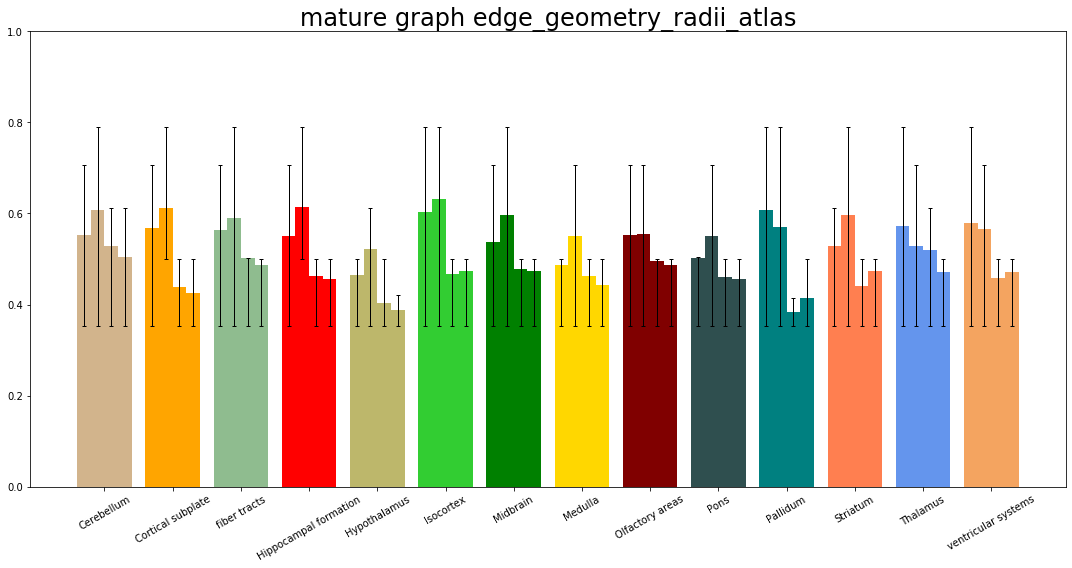

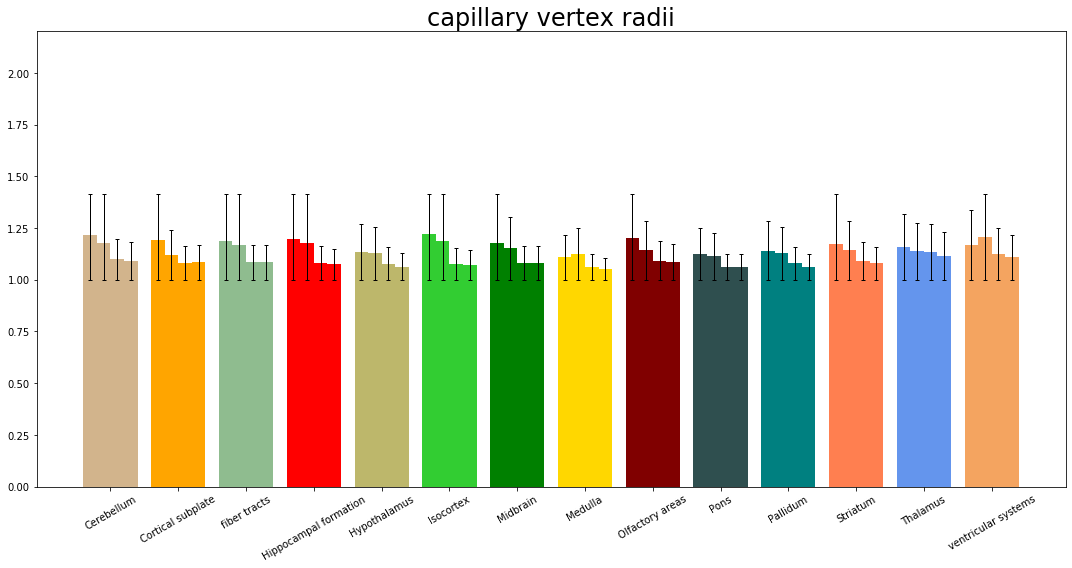

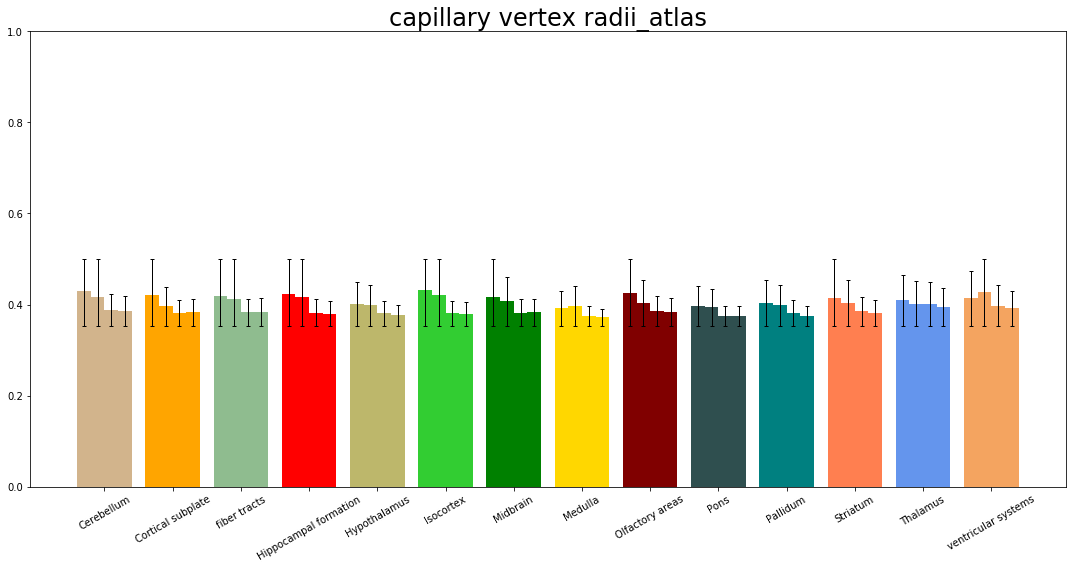

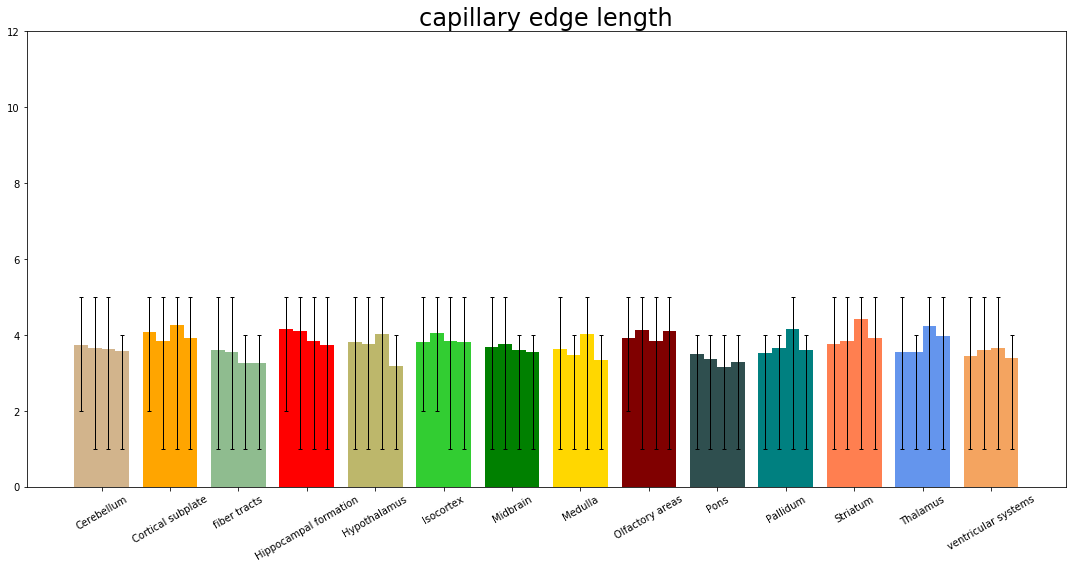

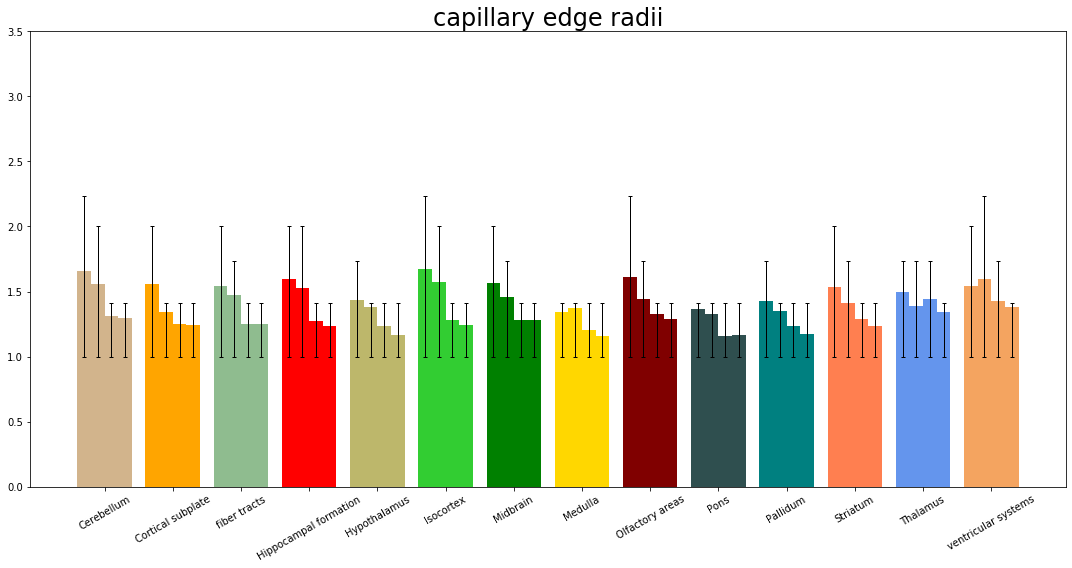

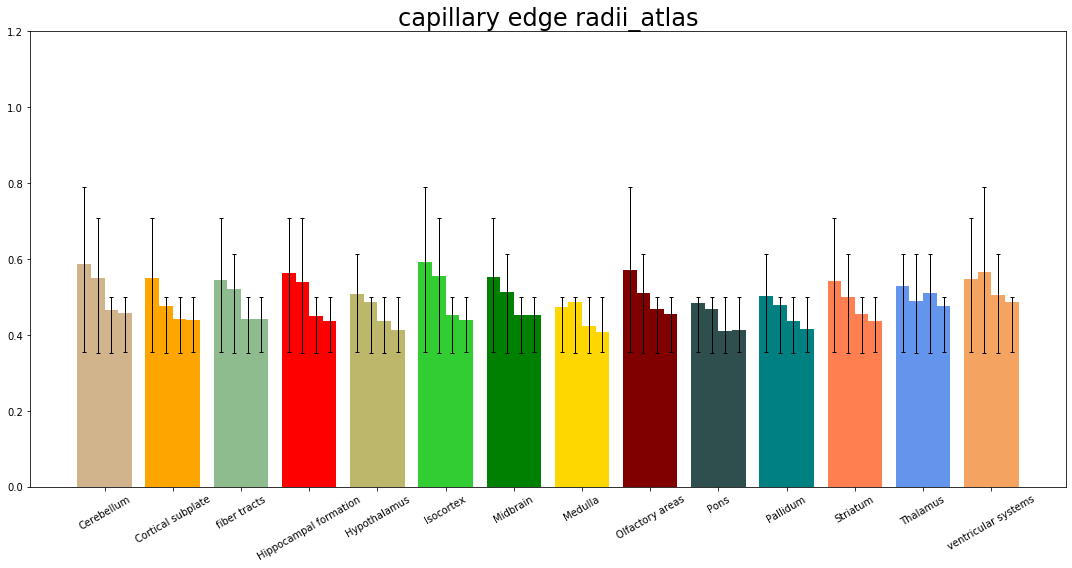

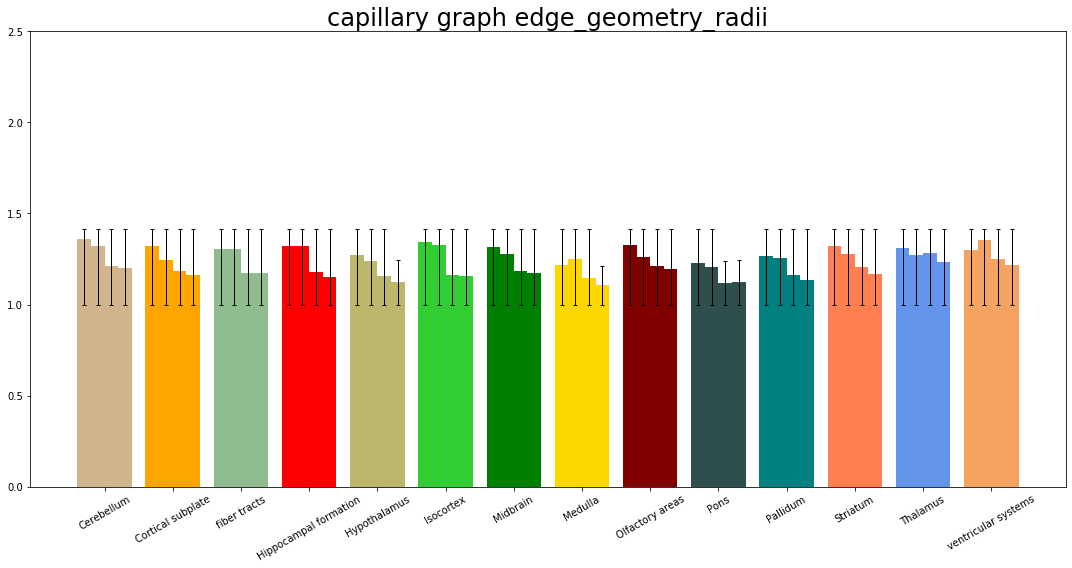

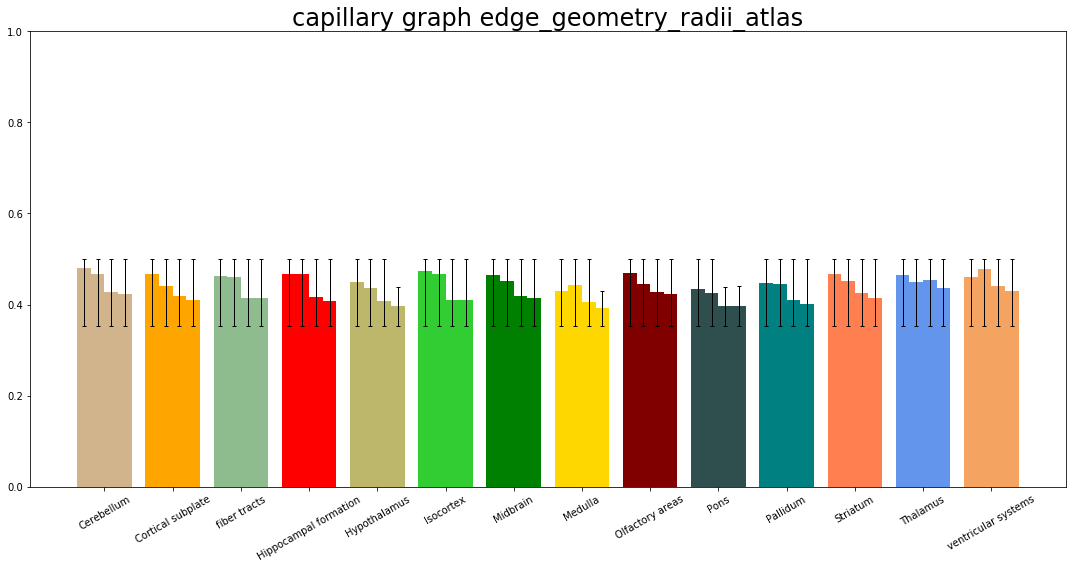

In [ ]:
# Radii of Vertex, Edge
# Length of Vertex, Edge
dic = {"mature" : {"vertex" : ("radii", "radii_atlas"),
                   "edge" : ("length", "radii", "radii_atlas"),
                   "graph" : ("edge_geometry_radii", "edge_geometry_radii_atlas")},
       "capillary" : {"vertex" : ("radii", "radii_atlas"),
                     "edge" : ("length", "radii", "radii_atlas"),
                      "graph" : ("edge_geometry_radii", "edge_geometry_radii_atlas")}}

scale_dic = {"vertex" : {"radii" : 2.2, 
                         "radii_atlas" : 1},
             "edge" : {"length" : 12,
                       "radii" : 3.5,
                       "radii_atlas" : 1.2},
             "graph" : {"edge_geometry_radii" : 2.5,
                        "edge_geometry_radii_atlas" : 1}}

df_dict = {}

for channel, item in dic.items():
    df_dic = {}
    for properties_name, p in item.items():
        for properties in p:
            savename = f"{channel}_{properties_name}_{properties}.png"
            df = plotBarAllGraph(gs_list, channel=channel, properties_name=properties_name, properties=properties,
                                 scale_dic=scale_dic, savedir=savedir, savename=savename, save=True, returndf=True)
            df_dic[f"{properties_name} {properties}"] = df
    df_dict[channel] = df_dic

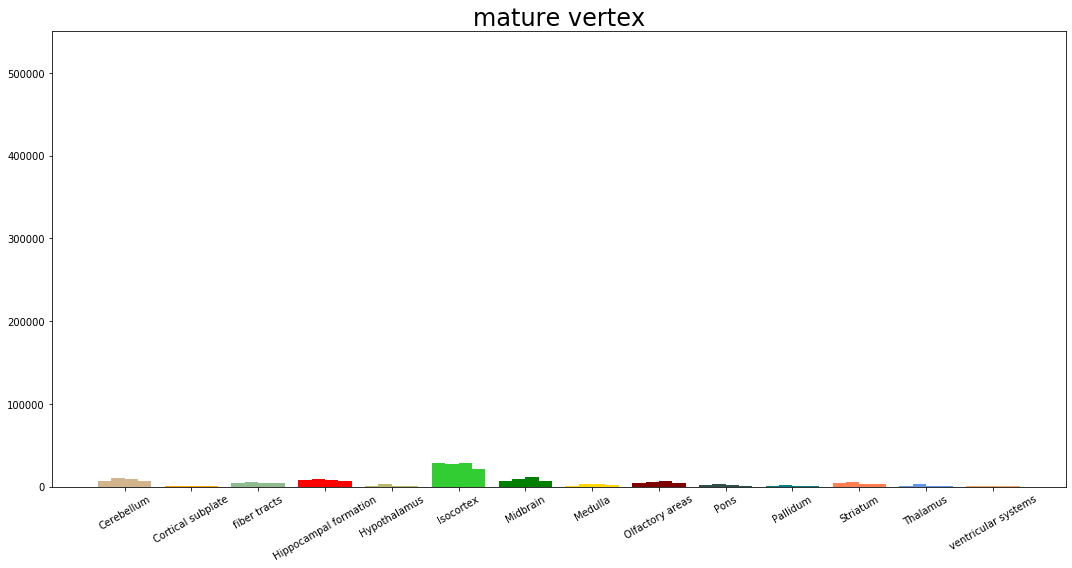

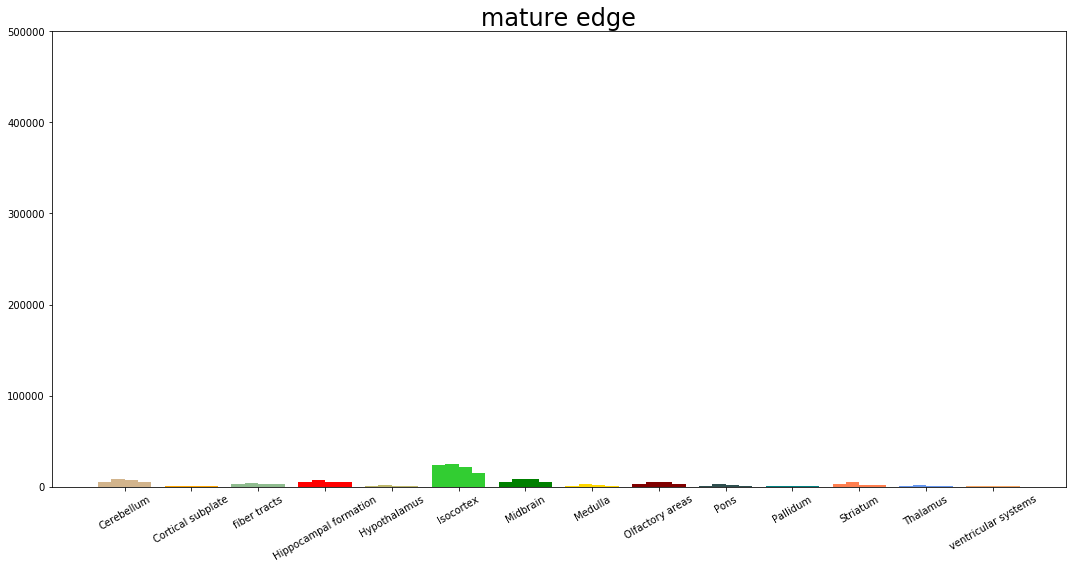

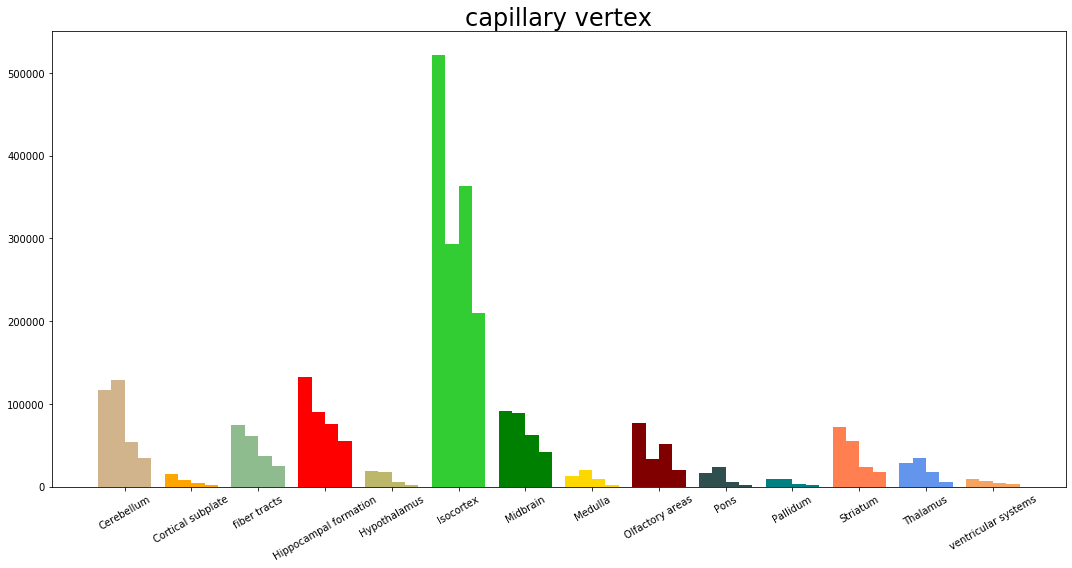

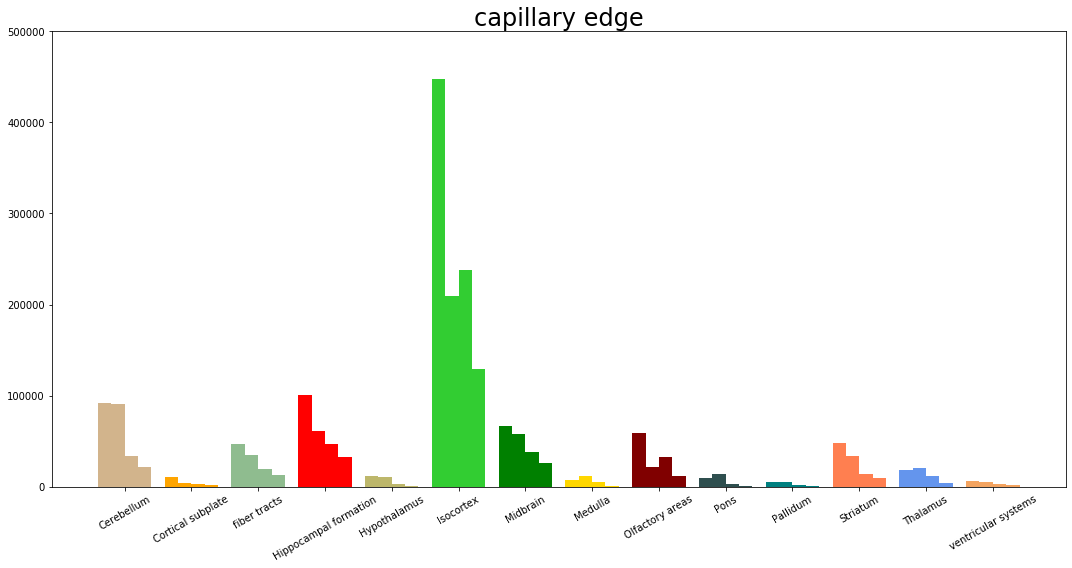

In [ ]:
# Number of Vertex, Edge
dic = {"mature" : ("vertex", "edge"),
       "capillary" : ("vertex", "edge")}

scale_dic = {"vertex" : 550000,
             "edge" : 500000}

for channel, item in dic.items():
    for properties_name in item:
        savename = f"{channel}_{properties_name}.png"
        df = plotBarAllGraph_VertexEdge(gs_list, channel=channel, properties_name=properties_name, scale_dic=scale_dic,
                                   savename=savename, savedir=savedir, save=True, returndf=True)
        df_dict[channel][properties_name] = df

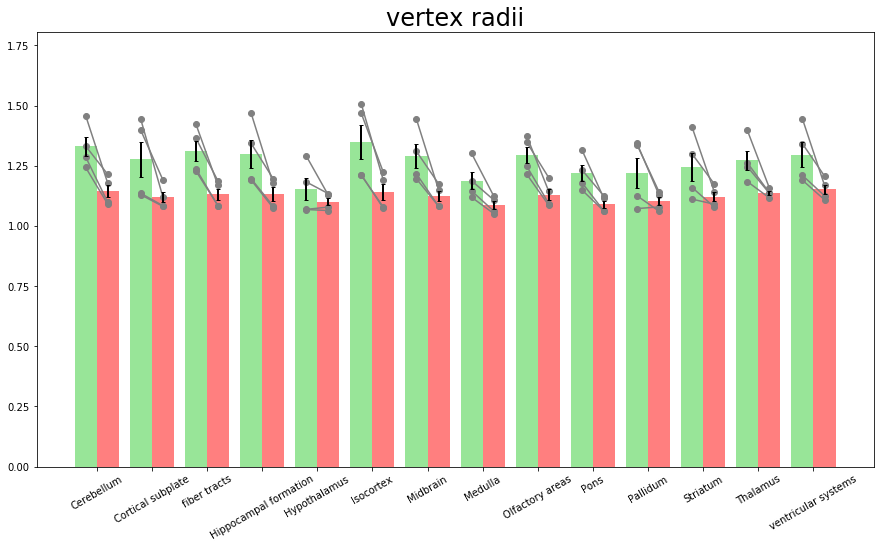

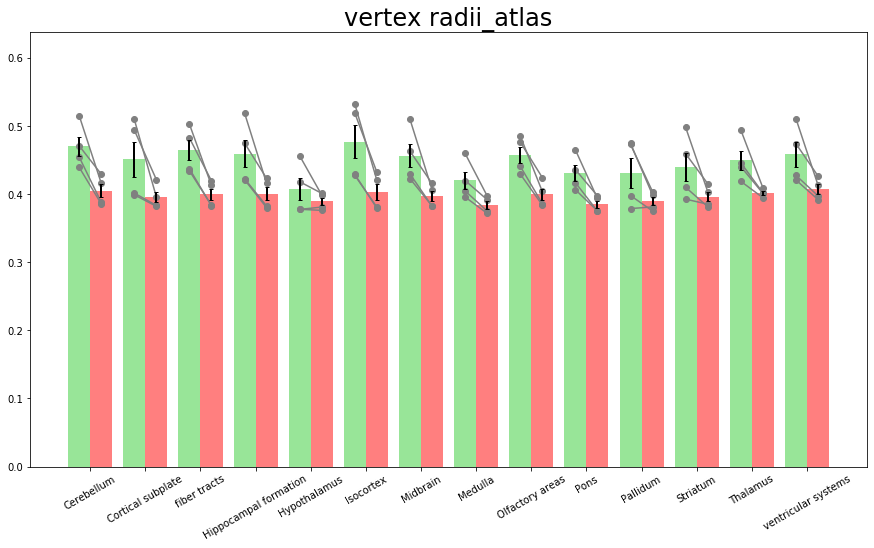

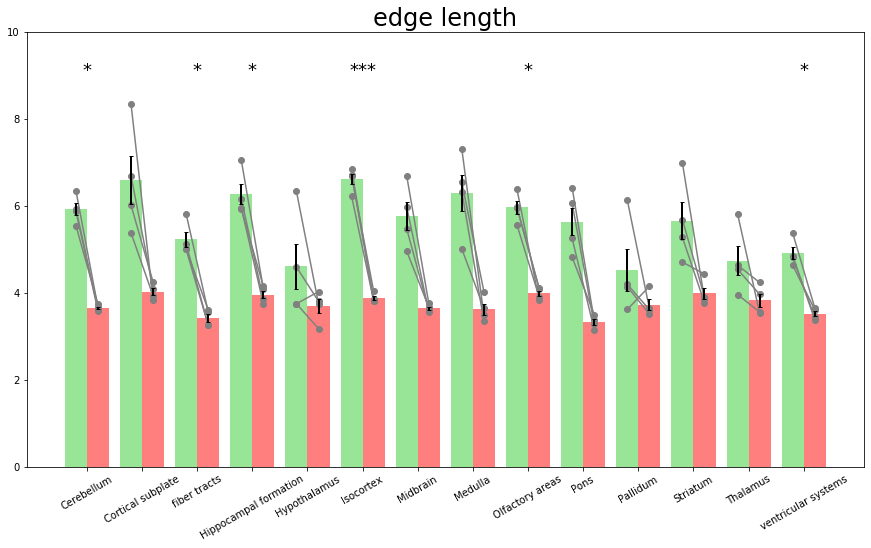

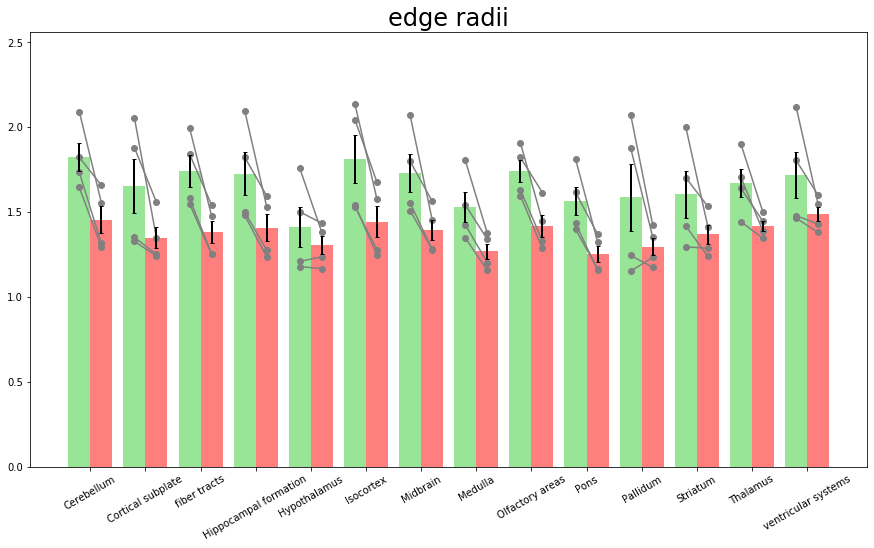

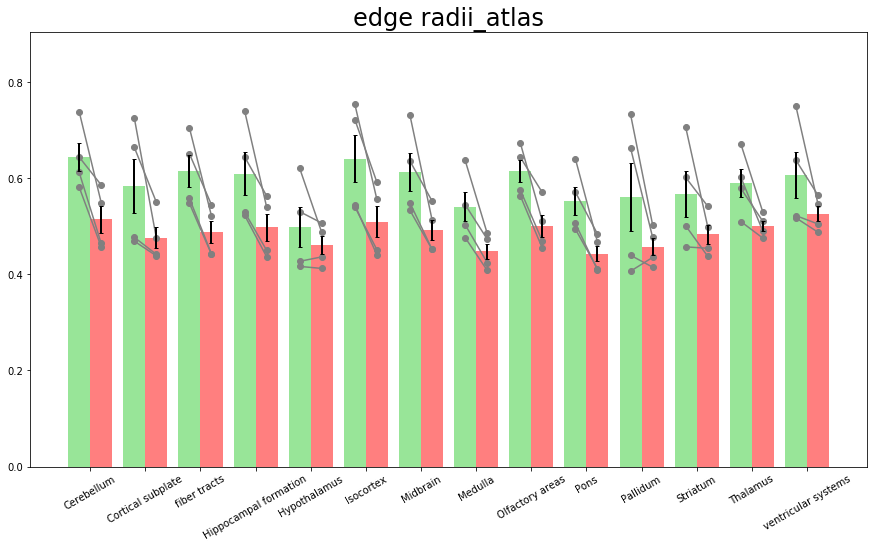

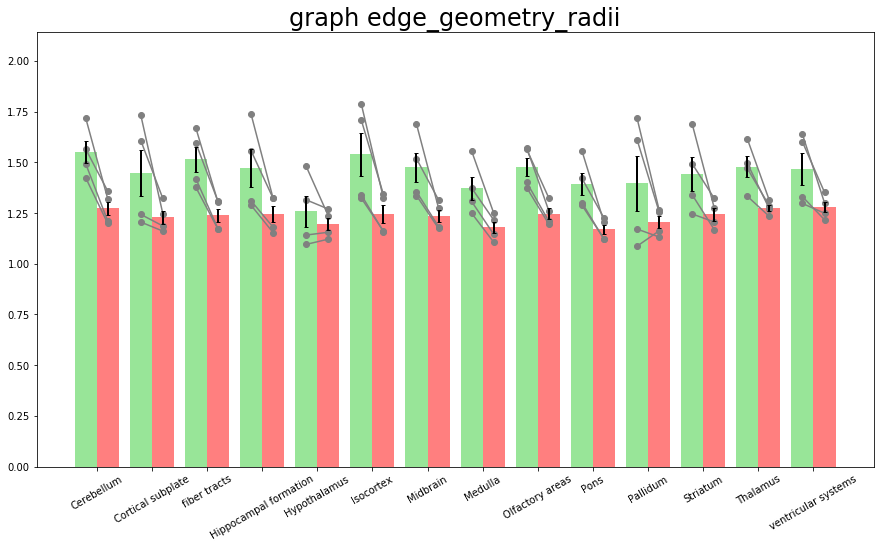

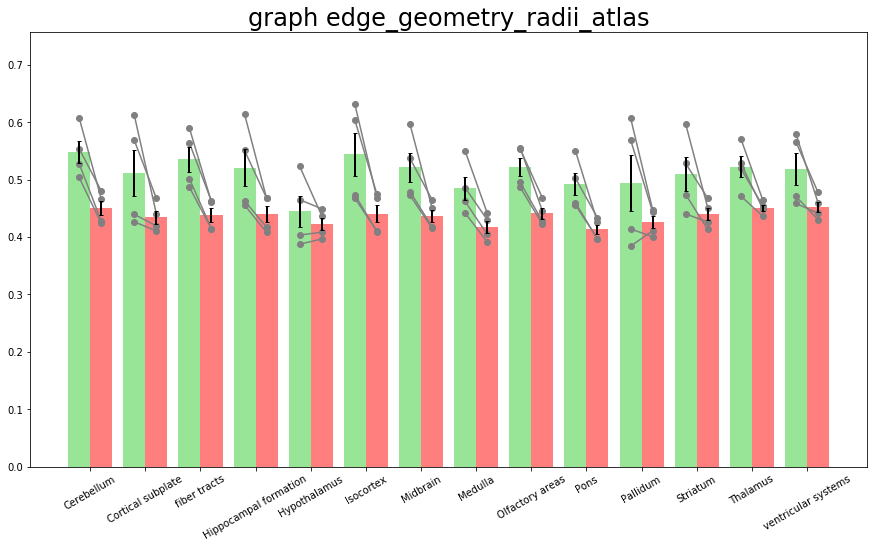

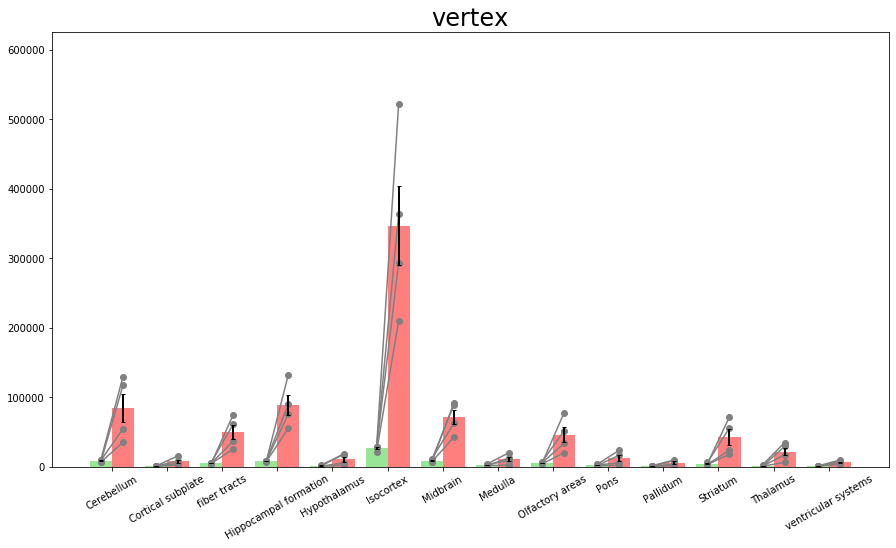

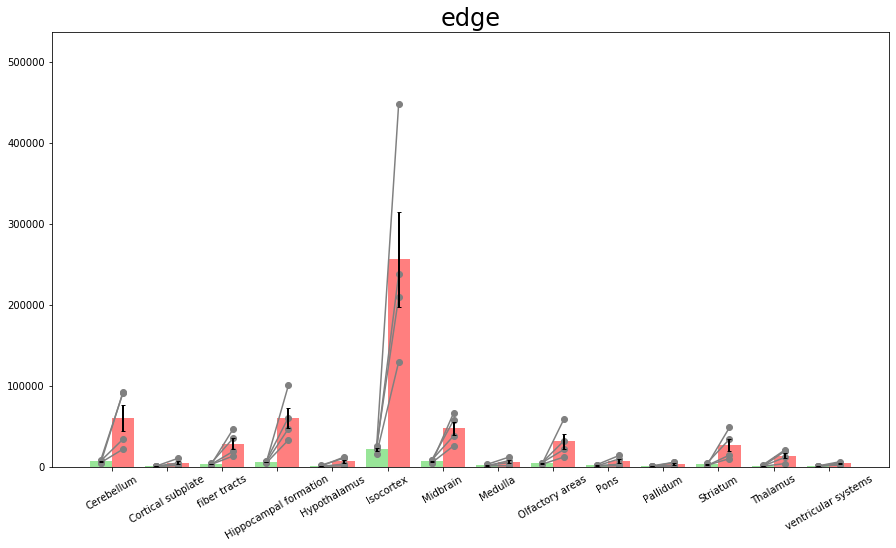

Cerebellum  Cortical subplate  fiber tracts  \
vertex radii                       0.187366           1.000000      0.074912   
vertex radii_atlas                 0.186863           1.000000      0.074691   
edge length                        0.014991           0.458742      0.027995   
edge radii                         0.250682           1.000000      0.090104   
edge radii_atlas                   0.250205           1.000000      0.089798   
graph edge_geometry_radii          0.106324           1.000000      0.054796   
graph edge_geometry_radii_atlas    0.105948           1.000000      0.054633   
vertex                             0.632262           1.000000      0.400341   
edge                               0.877256           1.000000      0.615530   

                                 Hippocampal formation  Hypothalamus  \
vertex radii                                  0.406375           1.0   
vertex radii_atlas                            0.405696           1.0   
edge length                                   0.034570           1.0   
edge radii                                    0.452343           1.0   
edge radii_atlas                              0.451585           1.0   
graph edge_geometry_radii                     0.582306           1.0   
graph edge_geometry_radii_atlas               0.581593           1.0   
vertex                                        0.218797           1.0   
edge                                          0.457341           1.0   

                                 Isocortex  Midbrain   Medulla  \
vertex radii                      0.254744  0.376339  0.380225   
vertex radii_atlas                0.254469  0.375640  0.379515   
edge length                       0.003796  0.128768  0.191178   
edge radii                        0.173971  0.498326  0.261139   
edge radii_atlas                  0.173646  0.497502  0.260554   
graph edge_geometry_radii         0.390213  0.389541  0.211929   
graph edge_geometry_radii_atlas   0.389910  0.388861  0.211422   
vertex                            0.223994  0.179892  1.000000   
edge                              0.546871  0.306748  1.000000   

                                 Olfactory areas      Pons  Pallidum  \
vertex radii                            0.071277  0.198484  1.000000   
vertex radii_atlas                      0.071009  0.197984  1.000000   
edge length                             0.028092  0.131065  1.000000   
edge radii                              0.124065  0.198857  1.000000   
edge radii_atlas                        0.123734  0.198353  1.000000   
graph edge_geometry_radii               0.061527  0.197297  1.000000   
graph edge_geometry_radii_atlas         0.061369  0.196835  1.000000   
vertex                                  0.657725  1.000000  0.887520   
edge                                    1.000000  1.000000  0.962566   

                                 Striatum  Thalamus  ventricular systems  
vertex radii                     1.000000  0.480782             0.711255  
vertex radii_atlas               1.000000  0.481424             0.712087  
edge length                      0.910157  1.000000             0.032783  
edge radii                       1.000000  0.457182             1.000000  
edge radii_atlas                 1.000000  0.457470             1.000000  
graph edge_geometry_radii        1.000000  0.242279             0.899135  
graph edge_geometry_radii_atlas  1.000000  0.242489             0.899488  
vertex                           0.748636  0.589129             0.394697  
edge                             0.961084  0.548920             0.365775

In [ ]:
pvalue_dict = {}
for properties in df_dict["mature"].keys():
    # pvalue
    mat = np.array(df_dict["mature"][properties])
    cap = np.array(df_dict["capillary"][properties])
    pvalue = stats.ttest_rel(mat, cap).pvalue

    # Correction
    pvalue = pvalue * len(regions)
    pvalue[pvalue > 1] = 1
    pvalue_dict[properties] = pvalue
    
    # Plot
    y_list = [mat, cap]
    y_mean_list = [np.mean(mat, axis=0), np.mean(cap, axis=0)]
    y_err_list = [np.std(mat, axis=0)/np.sqrt(len(mat)), np.std(cap, axis=0)/np.sqrt(len(cap))]
    color_list = ["limegreen", "red"]
    width = 0.4
    
    plt.figure(figsize=(15,8))
    plt.title(properties, fontsize=24)
    ymax = np.array(y_list).max()*1.2
    plt.ylim(0, ymax)
    for i in range(len(y_list)):
        x = np.arange(len(regions)) + (i - 0.5) * width
        y = y_list[i]
        y_mean = y_mean_list[i]
        y_err = y_err_list[i]
        color = color_list[i]
        
        plt.bar(x, y_mean, width=width, color=color, alpha=0.5)
        plt.errorbar(x, y_mean, yerr=y_err, capsize=2, color="black", fmt="o", markersize=0, linewidth=2, zorder=3)
        plt.xticks(np.arange(len(regions)), regions.keys(), rotation=30, fontsize=10)
        
    # Scatter
    for i in range(len(regions)):
        ma = mat[:,i]
        ca = cap[:,i]
        for m, c in zip(ma, ca):
            x = np.array([-width*0.5, width*0.5]) + i
            plt.plot(x, (m,c), color="gray", marker="o")
            
    # pvalue plot
    for i in range(len(regions)):
        p = pvalue[i]
        if p < 0.001:
            plt.text(i, ymax*0.9, "****", ha="center", fontsize=18)
        elif p < 0.005:
            plt.text(i, ymax*0.9, "***", ha="center", fontsize=18)
        elif p < 0.01:
            plt.text(i, ymax*0.9, "**", ha="center", fontsize=18)
        elif p < 0.05:
            plt.text(i, ymax*0.9, "*", ha="center", fontsize=18)

    savename = savename = f"ttest {properties}.png"
    plt.savefig(f"{savedir}/{savename}", dpi=256)
    plt.show()
    
pvalue_df = pd.DataFrame(pvalue_dict, index=regions).T
pvalue_df.to_csv(f"{savedir}/ttest.csv")
display(pvalue_df)

In [ ]:
# Export DataFrames of each property(Vertex number, Edge number, etc.)
for group in df_dict.keys():
    df_dict_group = df_dict[group]
    for property in df_dict_group.keys():
        df = pd.DataFrame(df_dict_group[property])
        df.to_csv(f"{savedir}/{group} {property}.csv")

# Fibrosis

In [ ]:
d = Data("../Data/data_fig6c(fibrosis)")
gdirs = d.searchFile(extension="gt",name=["graph_reduced"])
print(gdirs)

['../Data/data_fig6c(fibrosis)/bleomycin/no160/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/bleomycin/no190/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/bleomycin/no203/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/bleomycin/no205/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/bleomycin/no225/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/bleomycin/no257/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/control/no140/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/control/no141/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/control/no197/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/saline/no159/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/saline/no188/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/saline/no189/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/saline/no204/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/saline/no223/graph_reduced.gt', '../Data/data_fig6c(fibrosis)/saline/no224/graph_reduced.gt']


In [ ]:
savedir = os.path.join(resultdir, "fibrosis")
if not os.path.exists(savedir):
    os.mkdir(savedir)

In [ ]:
groups = ["control", "saline", "bleomycin"]
g_dict = {}

for group in groups:
    g_list = []
    for mouse in [gdir for gdir in gdirs if group in gdir]:
        directory = mouse.rsplit("/",1)[0]
        resources_directory = settings.resources_path
        ws = wsp.Workspace('TubeMap', directory=directory)
        g_list += [grp.load(ws.filename('graph', postfix='reduced'))]
    g_dict[group] = g_list
    
print(g_dict)

{'control': [Graph[72726·][47595-]|G|, Graph[94748·][66263-]|G|, Graph[86144·][62739-]|G|], 'saline': [Graph[86138·][61351-]|G|, Graph[54330·][37325-]|G|, Graph[59558·][37351-]|G|, Graph[78932·][52924-]|G|, Graph[39997·][24675-]|G|, Graph[70787·][49178-]|G|], 'bleomycin': [Graph[21424·][11977-]|G|, Graph[35196·][20579-]|G|, Graph[65300·][40239-]|G|, Graph[17732·][10364-]|G|, Graph[66936·][43842-]|G|, Graph[41332·][24230-]|G|]}


In [ ]:
def plotBarAllGraph(g_dict, properties_name, properties, savedir, savename=None, save=False, returndf=True):
    y_means = []
    y_stds = []
    y_percentiles1 = []
    y_percentiles2 = []
    
    for group, g_list in g_dict.items():
            
        y_mean = []
        y_std = []
        y_percentile1 = []
        y_percentile2 = []
        for g in g_list:
            if properties_name == "vertex":
                arr = g.vertex_property(name=properties)
            elif properties_name == "edge":
                arr = g.edge_property(name=properties)
            elif properties_name == "graph":
                arr = g.graph_property(name=properties)

            y_mean += [np.mean(arr)]
            y_std += [np.std(arr)]
            y_percentile1 += [np.percentile(arr, 25)]
            y_percentile2 += [np.percentile(arr, 75)]
        y_means += [y_mean]
        y_stds += [y_std]
        y_percentiles1 += [y_percentile1]
        y_percentiles2 += [y_percentile2]
        
    # Plot
    color_list = ["blue", "red", "green", "purple"]
    width = 0.1
    
    plt.figure(figsize=(15,8))
    plt.title(f"{properties_name} {properties}", fontsize=24)
    for i in range(len(g_dict)):
        y_mean = np.array(y_means[i])
        y_std = np.array(y_stds[i])
        y_percentile1 = np.array(y_percentiles1[i])
        y_percentile2 = np.array(y_percentiles2[i])
        y_err = np.array([abs(y_mean - y_percentile1), abs(y_mean - y_percentile2)])
        x = np.arange(i, i+len(y_mean)*width-0.01, width) - ((len(y_mean) / 2) - 0.5) * width
        
        color = color_list[i]
        plt.bar(x, y_mean, width=width, color=color, alpha=0.5)
#         plt.errorbar(x, y_mean, y_std, capsize=2, color="black", fmt="o", markersize=0, linewidth=1)
        plt.errorbar(x, y_mean, yerr=y_err, capsize=2, color="black", fmt="o", markersize=0, linewidth=1)
        plt.xticks(np.arange(len(list(g_dict.keys()))), list(g_dict.keys()), rotation=0, fontsize=16)
        
    if save:
        plt.savefig(f"{savedir}/{savename}", dpi=256)
    
    plt.show()
    
    if returndf:
        df = pd.DataFrame(y_means, index=groups)
        return df

In [ ]:
def plotBarAllGraph_VertexEdge(g_dict, properties_name, savedir, savename=None, save=False, returndf=True):
    nums = []
    
    for group, g_list in g_dict.items():
        num = []
        for g in g_list:
            if properties_name == "vertex":
                num += [len(g.vertices)]
            elif properties_name == "edge":
                num += [len(g.edges)]
                
        nums += [num]
        
    # Plot
    color_list = ["blue", "red", "green", "purple"]
    width = 0.1
    
    plt.figure(figsize=(15,8))
    plt.title(f"{properties_name}", fontsize=24)
    for i in range(len(g_dict)):
        num = nums[i]
        x = np.arange(i, i+len(num)*width-0.01, width) - ((len(num) / 2) - 0.5) * width
        
        color = color_list[i]
        plt.bar(x, num, width=width, color=color, alpha=0.5)
        plt.xticks(np.arange(len(list(g_dict.keys()))), list(g_dict.keys()), rotation=0, fontsize=16)
        
    if save:
        plt.savefig(f"{savedir}/{savename}", dpi=256)
    
    plt.show()
    
    if returndf:
        df = pd.DataFrame(nums, index=groups)
        return df

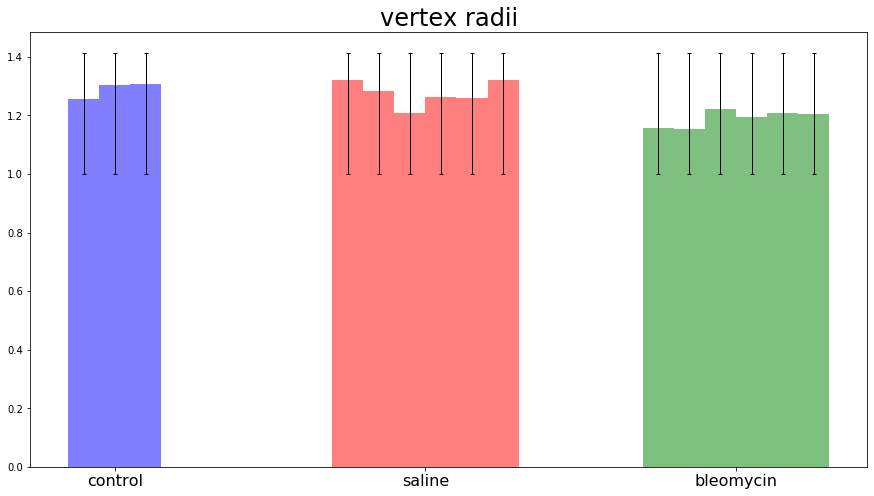

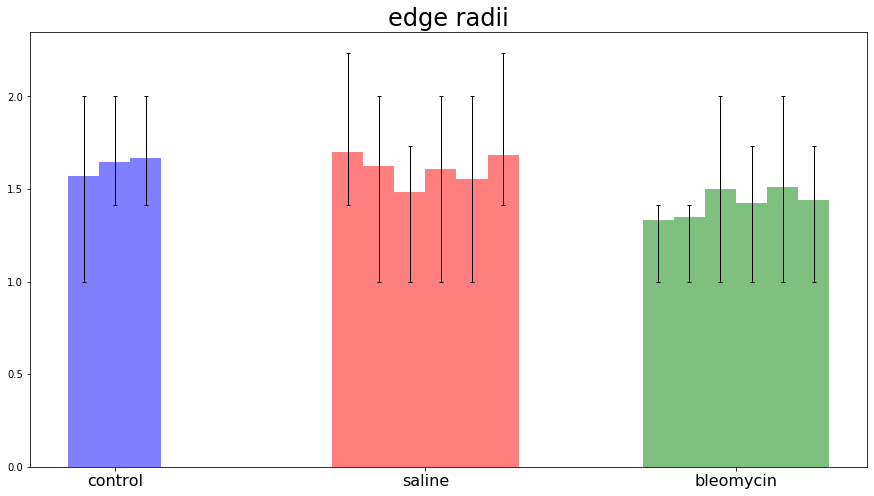

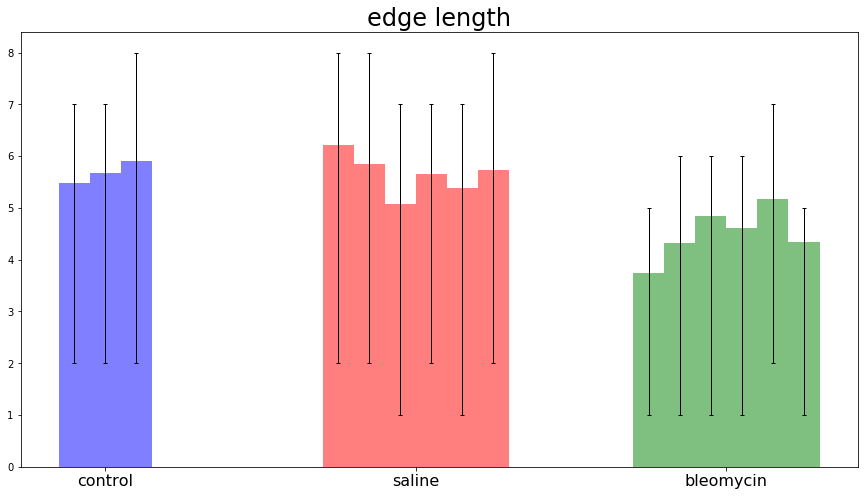

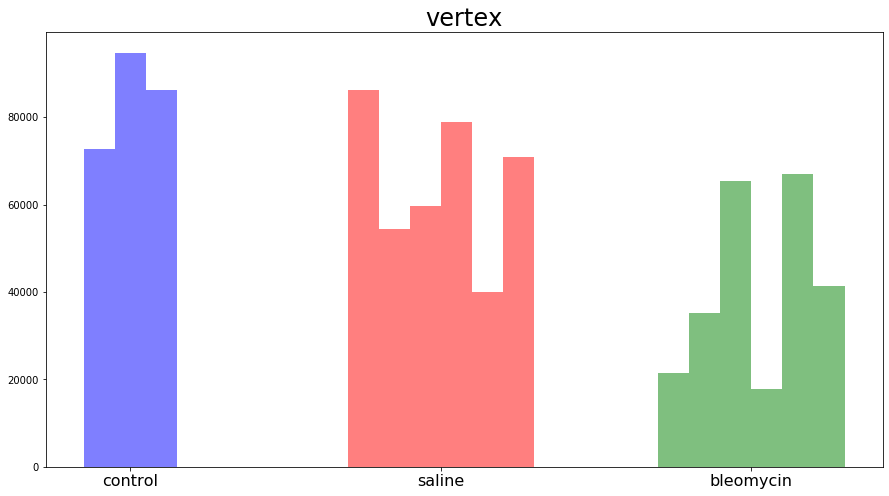

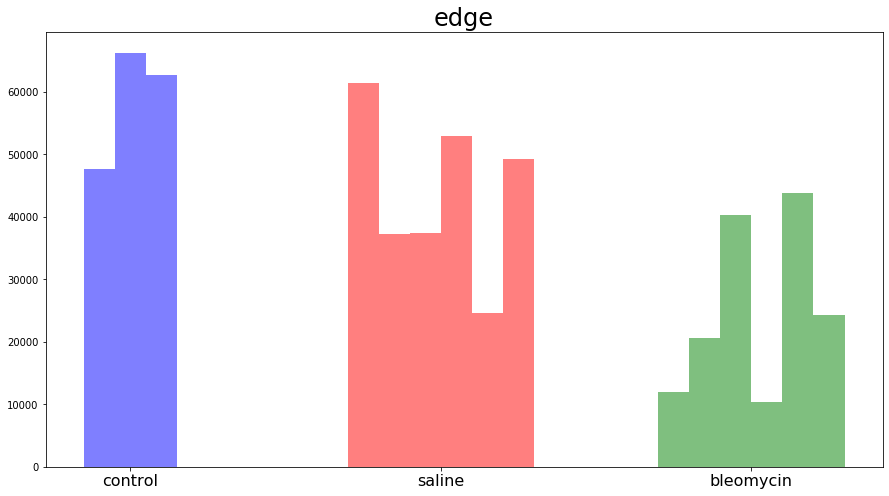

{'vertex radii':                   0         1         2         3         4         5
 control    1.254436  1.302332  1.307181       NaN       NaN       NaN
 saline     1.319503  1.283404  1.206483  1.261765  1.260786  1.320597
 bleomycin  1.155266  1.152425  1.221435  1.196050  1.208893  1.204848,
 'edge radii':                   0         1         2         3         4         5
 control    1.570881  1.646929  1.664625       NaN       NaN       NaN
 saline     1.699963  1.625325  1.481477  1.607373  1.554242  1.684151
 bleomycin  1.331227  1.350580  1.501734  1.422554  1.510444  1.437746,
 'edge length':                   0         1         2         3         4         5
 control    5.474777  5.673936  5.902326       NaN       NaN       NaN
 saline     6.217356  5.851681  5.073278  5.647948  5.387558  5.737423
 bleomycin  3.745512  4.321250  4.850568  4.604400  5.173783  4.335411,
 'vertex':                0      1      2        3        4        5
 control    72726  94748  86144

In [ ]:
df_dict = {}

dic = {"vertex" : ("radii",),
       "edge" : ("radii", "length")}

for properties_name, item in dic.items():
    for properties in item:
        savename = f"{properties_name}_{properties}.png"
        df = plotBarAllGraph(g_dict, properties_name, properties, savedir, savename=savename, save=True, returndf=True)
        df_dict[f"{properties_name} {properties}"] = df
        
for properties_name in ["vertex", "edge"]:
    savename = f"{properties_name}.png"
    df = plotBarAllGraph_VertexEdge(g_dict, properties_name, savedir, savename=savename, save=True, returndf=True)
    df_dict[properties_name] = df
        
display(df_dict)

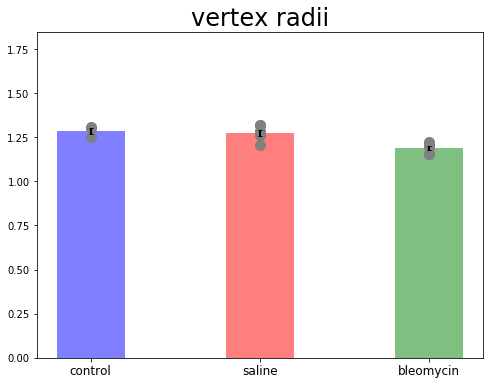

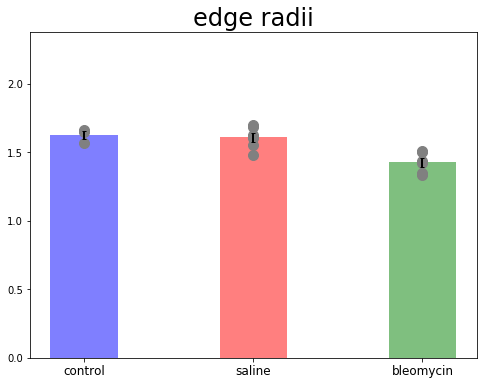

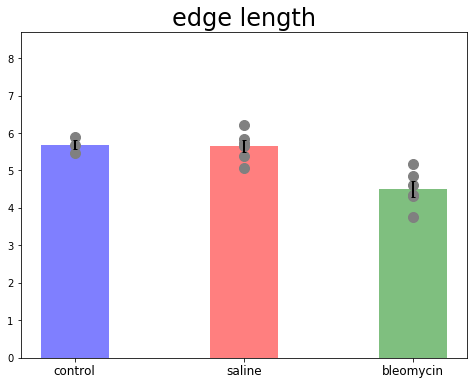

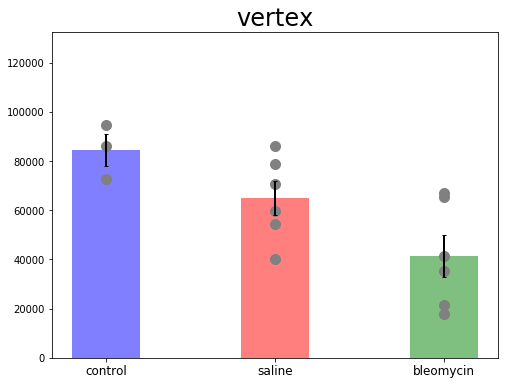

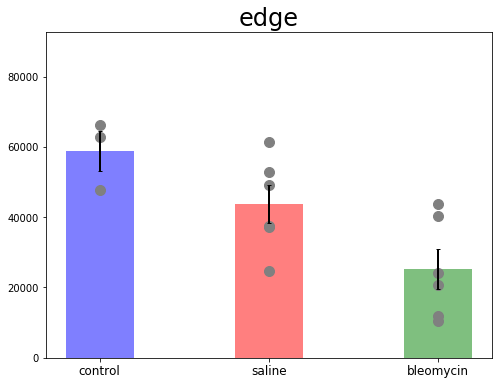

control_saline  control_bleomycin  saline_bleomycin
vertex radii        1.000000           0.006082          0.007002
edge radii          1.000000           0.012440          0.006919
edge length         1.000000           0.018720          0.003662
vertex              0.353509           0.041847          0.174448
edge                0.383837           0.024387          0.119583

In [ ]:
pvalue_dict = {}
for properties in df_dict.keys():
    df = df_dict[properties]
    # pvalue
    pvalue_dic = {}
    for combi in itertools.combinations(df.index, 2):
        group1 = df.T[combi[0]].dropna()
        group2 = df.T[combi[1]].dropna()
        # Correction
        pvalue = stats.ttest_ind(group1, group2).pvalue * len(list(itertools.combinations(df.index, 2)))
        if pvalue > 1:
            pvalue = 1
        pvalue_dic[f"{combi[0]}_{combi[1]}"] = pvalue
    pvalue_dict[properties] = pvalue_dic
    
    # Plot
    x = df.index
    ymax = np.array(df.fillna(0)).max()*1.4
    y = np.array(df)
    y_mean = df.mean(axis=1)
    y_err = df.sem(axis=1)
    color_list = ["blue", "red", "green", "purple"]
    width = 0.4
    
    plt.figure(figsize=(8,6))
    plt.title(properties, fontsize=24)

    plt.ylim(0, ymax)
    plt.bar(x, y_mean, width=width, color=color_list, alpha=0.5, zorder=1)
    plt.errorbar(x, y_mean, yerr=y_err, capsize=2, color="black", fmt="o", markersize=0, linewidth=2, zorder=3)
    plt.xticks(fontsize=12)
        
    # Scatter
    for s in y.T:
        plt.scatter(x=x, y=s, s=100, color="gray", zorder=2)

    savename = savename = f"ttest {properties}.png"
    plt.savefig(f"{savedir}/{savename}", dpi=256)
    plt.show()
    
pvalue_df = pd.DataFrame(pvalue_dict).T
pvalue_df.to_csv(f"{savedir}/ttest.csv")
display(pvalue_df)

In [ ]:
for property in df_dict.keys():
    df = pd.DataFrame(df_dict[property])
    df.to_csv(f"{savedir}/{property}.csv")

# Tumor

In [ ]:
d = Data("../Data/data_fig7f(tumor)")
gdirs = {}
groups = ["control", "day1", "day4", "day10"]

savedir = os.path.join(resultdir, "tumor")
if not os.path.exists(savedir):
    os.mkdir(savedir)

for group in groups:
    if group == "day1":
        gdir = d.searchFile(extension="gt",name=["graph_reduced", "day1"], exclude="day10")
    else:
        gdir = d.searchFile(extension="gt",name=["graph_reduced", group])
    gdirs[group] = gdir
print(gdirs)

{'control': ['../Data/data_fig7f(tumor)/control/no144/graph_reduced.gt', '../Data/data_fig7f(tumor)/control/no145/graph_reduced.gt', '../Data/data_fig7f(tumor)/control/no164/graph_reduced.gt'], 'day1': ['../Data/data_fig7f(tumor)/day1/no193/graph_reduced.gt', '../Data/data_fig7f(tumor)/day1/no198/graph_reduced.gt', '../Data/data_fig7f(tumor)/day1/no199/graph_reduced.gt', '../Data/data_fig7f(tumor)/day1/no241/graph_reduced.gt', '../Data/data_fig7f(tumor)/day1/no254/graph_reduced.gt'], 'day4': ['../Data/data_fig7f(tumor)/day4/no194/graph_reduced.gt', '../Data/data_fig7f(tumor)/day4/no200/graph_reduced.gt', '../Data/data_fig7f(tumor)/day4/no201/graph_reduced.gt', '../Data/data_fig7f(tumor)/day4/no233/graph_reduced.gt', '../Data/data_fig7f(tumor)/day4/no252/graph_reduced.gt'], 'day10': ['../Data/data_fig7f(tumor)/day10/no195/graph_reduced.gt', '../Data/data_fig7f(tumor)/day10/no196/graph_reduced.gt', '../Data/data_fig7f(tumor)/day10/no202/graph_reduced.gt', '../Data/data_fig7f(tumor)/day10

In [ ]:
g_dict = {}

for group in groups:
    g_list = []
    for mouse in gdirs[group]:
        g_list += [grp.load(mouse)]
    g_dict[group] = g_list
    
print(g_dict)

{'control': [Graph[75457·][53235-]|G|, Graph[81839·][58673-]|G|, Graph[58683·][40545-]|G|], 'day1': [Graph[69014·][53439-]|G|, Graph[89181·][76987-]|G|, Graph[73822·][55527-]|G|, Graph[98885·][68803-]|G|, Graph[107335·][77099-]|G|], 'day4': [Graph[86718·][65085-]|G|, Graph[120345·][85308-]|G|, Graph[110972·][77586-]|G|, Graph[57550·][41602-]|G|, Graph[70560·][48161-]|G|], 'day10': [Graph[85793·][59527-]|G|, Graph[88414·][59800-]|G|, Graph[83214·][54935-]|G|, Graph[98160·][76310-]|G|]}


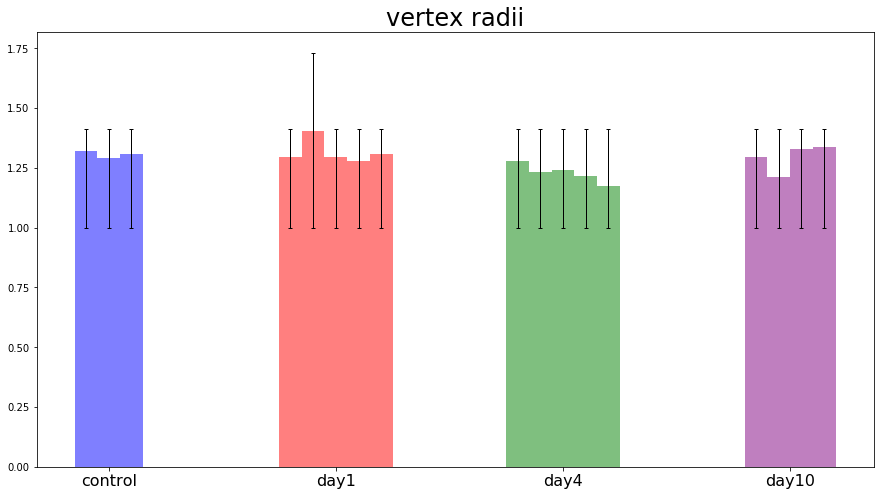

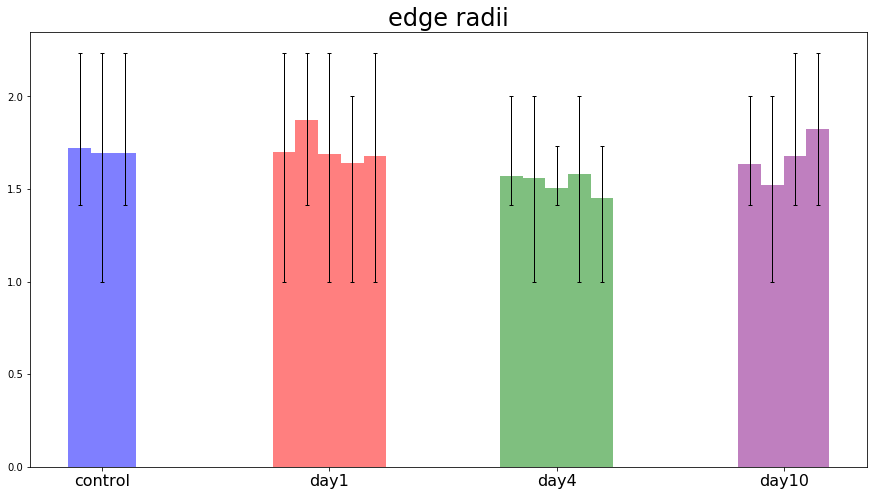

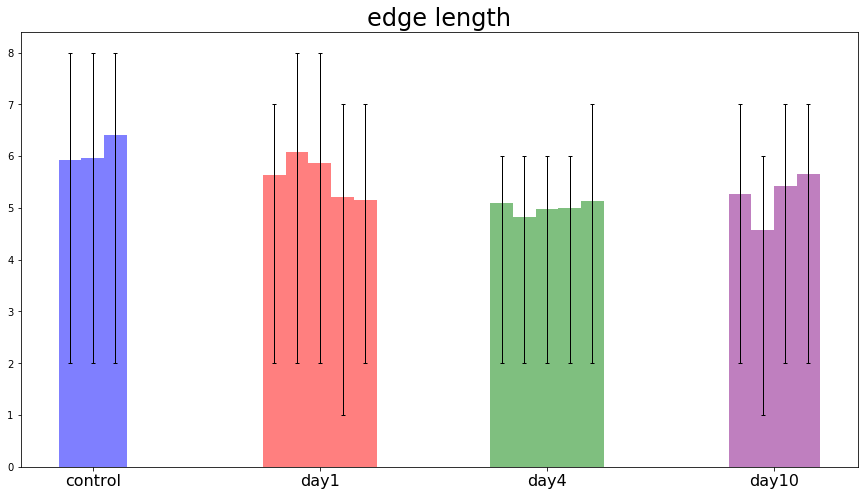

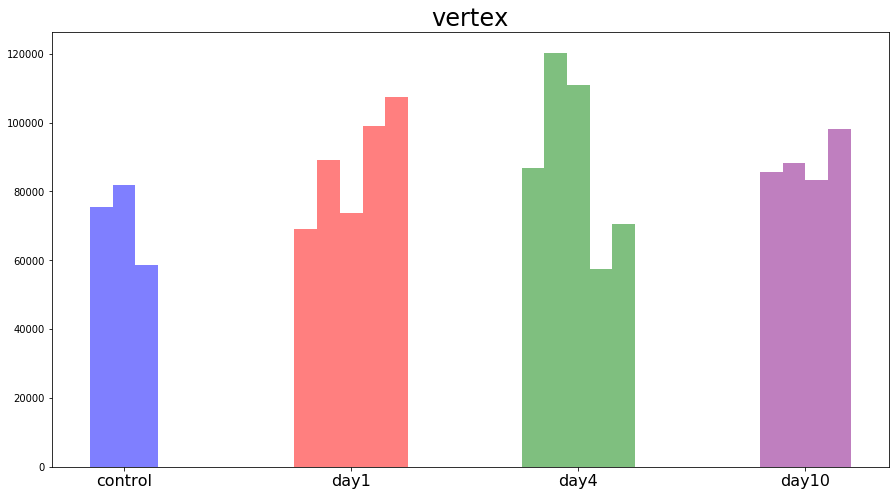

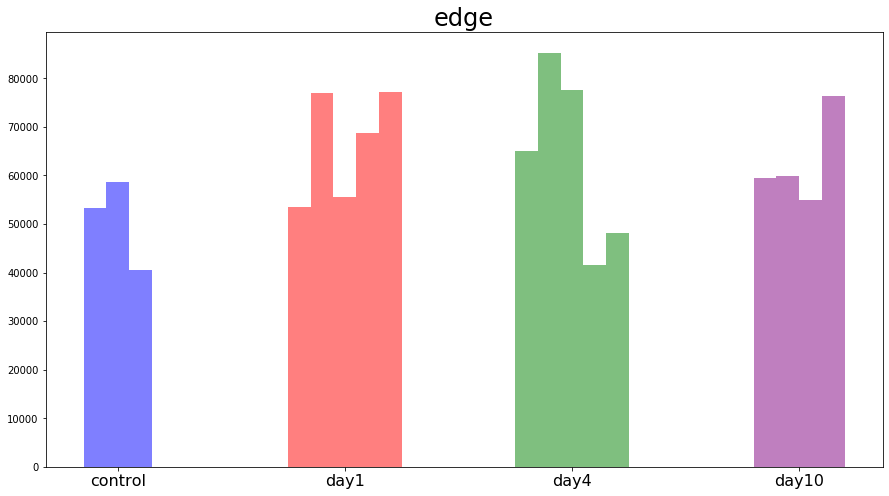

{'vertex radii':                 0         1         2         3         4
 control  1.320863  1.291264  1.308722       NaN       NaN
 day1     1.293718  1.405550  1.296414  1.279765  1.306821
 day4     1.276822  1.232278  1.239903  1.216110  1.174063
 day10    1.294425  1.213921  1.329434  1.337849       NaN,
 'edge radii':                 0         1         2         3         4
 control  1.720770  1.693223  1.696663       NaN       NaN
 day1     1.702105  1.872339  1.686179  1.637721  1.676181
 day4     1.572516  1.561559  1.502936  1.578273  1.450851
 day10    1.634616  1.519640  1.679845  1.826221       NaN,
 'edge length':                 0         1         2         3         4
 control  5.929426  5.969339  6.412455       NaN       NaN
 day1     5.642845  6.074766  5.871126  5.206706  5.156280
 day4     5.091680  4.833837  4.970755  4.997524  5.128859
 day10    5.268433  4.564682  5.427560  5.660464       NaN,
 'vertex':              0       1       2        3         4
 contr

In [ ]:
df_dict = {}

dic = {"vertex" : ("radii",),
       "edge" : ("radii", "length")}

for properties_name, item in dic.items():
    for properties in item:
        savename = f"{properties_name}_{properties}.png"
        df = plotBarAllGraph(g_dict, properties_name, properties, savedir, savename=savename, save=True, returndf=True)
        df_dict[f"{properties_name} {properties}"] = df
        
for properties_name in ["vertex", "edge"]:
    savename = f"{properties_name}.png"
    df = plotBarAllGraph_VertexEdge(g_dict, properties_name, savedir, savename=savename, save=True, returndf=True)
    df_dict[properties_name] = df
        
display(df_dict)

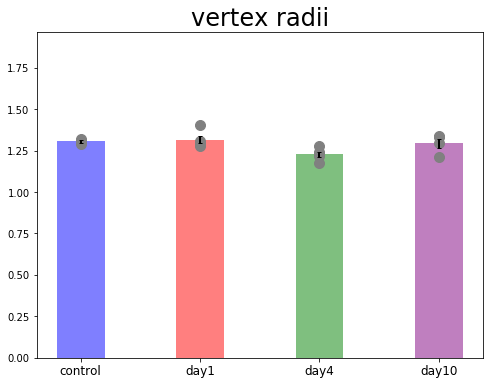

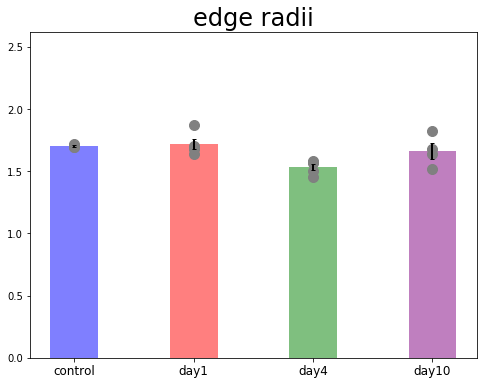

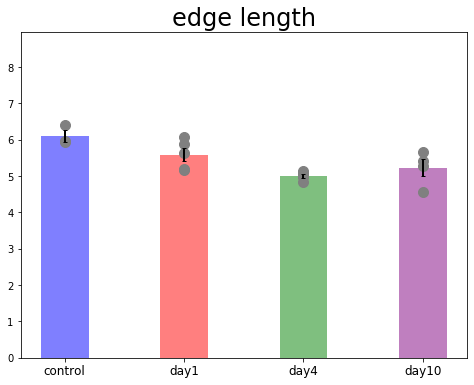

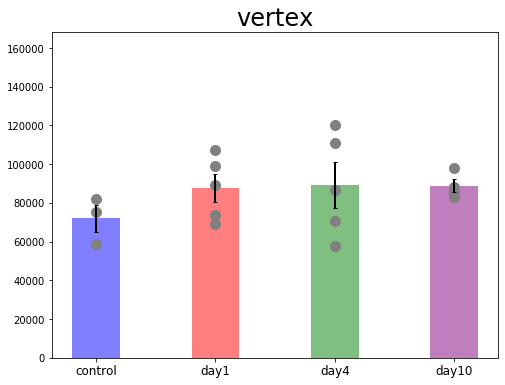

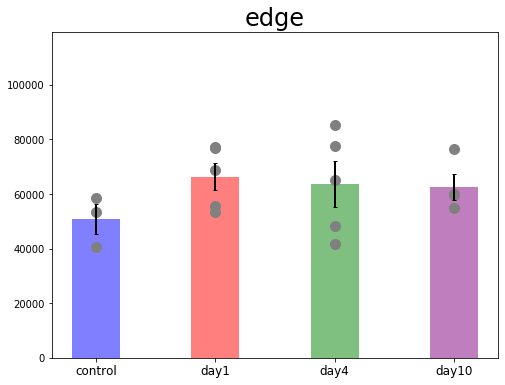

control_day1  control_day4  control_day10  day1_day4  \
vertex radii      1.000000      0.085351       1.000000   0.082332   
edge radii        1.000000      0.013279       1.000000   0.030670   
edge length       0.610603      0.000992       0.218122   0.085414   
vertex            1.000000      1.000000       0.355475   1.000000   
edge              0.567253      1.000000       0.951725   1.000000   

              day1_day10  day4_day10  
vertex radii         1.0    0.433701  
edge radii           1.0    0.432247  
edge length          1.0    1.000000  
vertex               1.0    1.000000  
edge                 1.0    1.000000

In [ ]:
pvalue_dict = {}
for properties in df_dict.keys():
    df = df_dict[properties]
    # pvalue
    pvalue_dic = {}
    for combi in itertools.combinations(df.index, 2):
        group1 = df.T[combi[0]].dropna()
        group2 = df.T[combi[1]].dropna()
        # Correction
        pvalue = stats.ttest_ind(group1, group2).pvalue * len(list(itertools.combinations(df.index, 2)))
        if pvalue > 1:
            pvalue = 1
        pvalue_dic[f"{combi[0]}_{combi[1]}"] = pvalue
    pvalue_dict[properties] = pvalue_dic
    
    # Plot
    x = df.index
    ymax = np.array(df.fillna(0)).max()*1.4
    y = np.array(df)
    y_mean = df.mean(axis=1)
    y_err = df.sem(axis=1)
    color_list = ["blue", "red", "green", "purple"]
    width = 0.4
    
    plt.figure(figsize=(8,6))
    plt.title(properties, fontsize=24)

    plt.ylim(0, ymax)
    plt.bar(x, y_mean, width=width, color=color_list, alpha=0.5, zorder=1)
    plt.errorbar(x, y_mean, yerr=y_err, capsize=2, color="black", fmt="o", markersize=0, linewidth=2, zorder=3)
    plt.xticks(fontsize=12)
        
    # Scatter
    for s in y.T:
        plt.scatter(x=x, y=s, s=100, color="gray", zorder=2)

    savename = savename = f"ttest {properties}.png"
    plt.savefig(f"{savedir}/{savename}", dpi=256)
    plt.show()
    
pvalue_df = pd.DataFrame(pvalue_dict).T
pvalue_df.to_csv(f"{savedir}/ttest.csv")
display(pvalue_df)

In [ ]:
for property in df_dict.keys():
    df = pd.DataFrame(df_dict[property])
    df.to_csv(f"{savedir}/{property}.csv")